# Example of e-GGP prediction in the Graph Interaction environment

In [1]:
import os
import sys
import time
import torch
import gpytorch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,\
    mean_absolute_error

eggp_path = os.getcwd()
if not "evolving-ggp" in eggp_path:
    raise ValueError("Run the Jupyter notebook in the e-GGP folder")

if eggp_path not in sys.path:
    sys.path.append(eggp_path)

# E-GGP libraries
from e_ggp.utils.datasets import GraphInteraction
from e_ggp.evolving_gp import eGGP
from e_ggp.utils.kernel_utils import get_phi_mappings, get_graph_kernel
from e_ggp.utils.data_utils import extend_train_dataset, get_data_targets, \
    get_xy_from_data,  get_target_name, create_training_data, create_test_data
from e_ggp.utils.plot_utils import plot_2d_sphere_only, plot_2d

# Change matplotlib backend
matplotlib.use('TkAgg')


## Define the arguments

In [2]:
# First we define a class for the arguments and create the datasets
class Args:
    def __init__(self, df, dt, priors, fixed_adj):
        self.data_file = df
        self.data_test_folder = dt
        self.priors = priors
        self.fixed_adj = fixed_adj
        self.output_folder = "runs/"
        self.phi_node = "eye"
        self.new_dataset = True
        self.no_pkl = True
        self.root_kernel = "RBF"
        self.leaf_kernel = "RBF"
       
        
args = Args(df="datasets/graph_interaction_origin.npy",
            dt="datasets/graph_interaction_test/",
            priors=True, fixed_adj=False)


## Load the training and test data

In [21]:
train_dataset, train_dataset_name = create_training_data(args)
test_datasets, test_dataset_names = create_test_data(args)

# We will only use one test dataset
test_dataset = test_datasets[6]
test_dataset_name = test_dataset_names[6]
test_value = test_dataset_name[18:].replace("_", " ")
print("Test name = ", test_dataset_name)

Creating train dataset


Creating test dataset


Test name =  graph_interaction_Z_0_25


## Plot the dataset

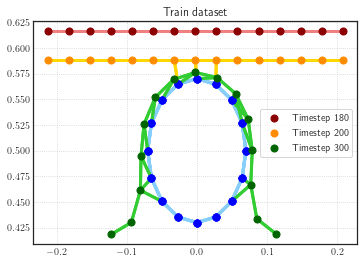

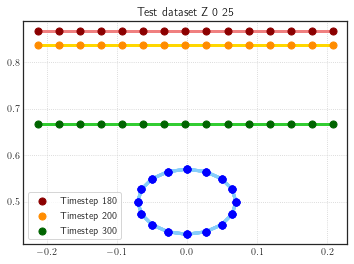

In [4]:
# Define the attributes dimension
horizon = train_dataset.timesteps  # Dimension N
nodes_nr = train_dataset.node_nr  # Dimension M
attr_dim = train_dataset.node_dim  # Dimension 2D+d

# Define which timepoints to plot
graph_idxs = [180, 200, 300]


def plot_dataset(dataset, graph_idxs, name):
    fig, ax = plt.subplots()
    colors = ["darkred", "darkorange", "darkgreen"]
    
    for idx in range(len(graph_idxs)):
        graph_t = dataset.graph_list[graph_idxs[idx]]
        nodes = graph_t.nodes
        adjacency = graph_t.adj_list
        if isinstance(dataset, GraphInteraction):
            plot_2d_sphere_only(ax, nodes, adjacency, marker_size=50, line_width=3)
        plot_2d(ax, nodes, adjacency=adjacency, color=colors[idx],
                label="Timestep " + str(graph_idxs[idx]),
                x_axis=0, y_axis=2, marker_size=50, line_width=3)
    plt.legend(frameon=True)
    plt.title(name)
    plt.show()

%matplotlib inline
plot_dataset(train_dataset, graph_idxs, name="Train dataset")
plot_dataset(test_dataset, graph_idxs, name="Test dataset " + test_value)


## Define the observations and target

In [5]:
# Single target index Vz = 5 for graph interaction dataset
target_idx = 5
# Define the timesteps to learn, in this case v_{t+1} = f(v_t)
step_size = 1  
# Get only 20 training points from the train dataset\n",
dataset_train_idx = get_data_targets(train_dataset, data_limit=20,
                                     target_id=target_idx,
                                     plot=False, output_folder="")
  
# Get the observation, target and adjacency matrix for training\n",
obs, target, adj_train = extend_train_dataset(train_dataset, step_size, dataset_train_idx,
                                              target_idx)


The final size of the training input is= 20


/home/mulerod1/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Define the model, kernel and load the model

In [6]:
model_type = "e-GGP"


# Transform the input to tensor form
X = torch.from_numpy(obs).double()
Y = torch.from_numpy(target).double().squeeze()

# Get the kernel
phi_node = get_phi_mappings(args)
kernel = get_graph_kernel(attr_dim, phi_node, args.root_kernel, args.leaf_kernel)

# Build the e-GGP
likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
e_ggp = eGGP(train_x=X, train_y=Y, likelihood=likelihood, kernel=kernel).double()

# Load the model
models_folder = os.path.join(eggp_path, "trained_models/graph_interaction")
model_path = os.path.join(models_folder, "eGGP_data_20_priors_True_RBF_Vz.pth")

state_dict = torch.load(model_path)
e_ggp.load_state_dict(state_dict)

# Move to evaluation mode
e_ggp.eval()
likelihood.eval()

# Show the parameters
kernel_params = e_ggp.covar_module.kernel_params
for key in kernel_params:
    print("Parameter name:", key, ", value=", kernel_params[key])



Parameter name: k_b_len , value= [[14.61650018930221, 0.9999999995475133, 3.692489867057499, 9.479615331987464, 0.9999999995475133, 1.885365106267116, 11.079409305302232]]
Parameter name: k_b_var , value= 1.6003960841908096
Parameter name: k_c_len , value= [[6.07321777172992, 0.9999999995475133, 5.851049352360329, 5.927426219428062, 0.9999999995475133, 3.318287929984123, 6.7514701088601115]]
Parameter name: k_c_var , value= 0.0023456759114519783


## Create a function to track the error metrics

In [7]:
def compute_onestep_metrics(gt_target, mean_gp, var_gp,
                            lists_dict,
                            multioutput="raw_values", only_rope=True):
    if only_rope:  # In case of the graph-interactiosn we only predict the rope
        gt_target = gt_target[:15, :]
        mean_gp = mean_gp[:15]
        var_gp = var_gp[:15]

    # Compute the RMSE
    rmse_gp = mean_squared_error(gt_target, mean_gp, multioutput=multioutput, squared=False)
    # Compute the MAPE
    mape_gp = mean_absolute_percentage_error(gt_target, mean_gp, multioutput=multioutput)
    # Compute the MAE
    mae_gp = mean_absolute_error(gt_target, mean_gp, multioutput=multioutput)

    # Sum over the nodes
    sum_result = np.sum(0.5 * np.log(2 * np.pi * var_gp) + (gt_target - mean_gp)**2 / (2 * var_gp), axis=1)
    nll = np.mean(sum_result, axis=0)  # Mean over the timesteps

    lists_dict['rmse'].append(rmse_gp)
    lists_dict['mae'].append(mae_gp)
    lists_dict['nll'].append(nll)
    lists_dict['mape'].append(mape_gp)
    lists_dict['gt'].append(gt_target)
    lists_dict['gp_pred'].append(mean_gp)
    lists_dict['gp_var'].append(var_gp)

    return lists_dict


## Predict on a single test datset

In [8]:
# Define the indexes to perform the test 
test_dataset_idx = np.linspace(0, test_dataset.timesteps - step_size - 1,
                               test_dataset.timesteps - step_size - 1, dtype=int)

# Create the lists for storing the results
lists_dict = {'rmse': [], 'mae': [], 'nll': [], 'mape': [],
              'gt': [], 'gp_pred': [], 'gp_var': []}

# Define what is the target name
target_name = get_target_name(test_dataset, target_idx)
name = test_dataset_name + "test data " + target_name

# Predict for each of the test nodes
time_taken = []
for idx in test_dataset_idx:
    nodes_test, adj_test, gt_target = get_xy_from_data(idx, step_size, 
                                                       test_dataset, target_idx)
    test = torch.from_numpy(nodes_test)
    
    # Predict the mean and variance
    start = time.time()
    f_pred = e_ggp(test, adj_list_1=adj_test, adj_list_2=adj_train)
    end = time.time()
    time_taken.append((end-start))
    mean_gp = f_pred.mean.detach().numpy()
    var_gp = f_pred.variance.detach().numpy()
    
    lists_dict = compute_onestep_metrics(gt_target=gt_target, mean_gp=mean_gp, 
                                         var_gp=var_gp, lists_dict=lists_dict)

print("Total time taken:=", np.array(time_taken).sum())
print("Average time prediction:=", np.array(time_taken).mean())


Total time taken:= 18842.74545931816
Average time prediction:= 37.83683827172322


In [18]:
# Compute the arrays of the mettrics
gp_pred_arr = np.array(lists_dict['gp_pred'])[:, :]

gp_var_arr = np.array(lists_dict['gp_var'])
gt_arr = np.array(lists_dict['gt'])[:, :, 0]
if len(gp_pred_arr.shape) > 2:
    gp_pred_arr = gp_pred_arr[:, :, 0]
if len(gp_var_arr.shape) > 2:
    gp_var_arr = gp_var_arr[:, :, 0]

# Error arrays
rmse_arr = np.array(lists_dict['rmse'])
mape_arr = np.array(lists_dict['mape'])
mae_arr = np.array(lists_dict['mae'])
# Get the correct NLL
nll_arr = np.sum(0.5 * np.log(2 * np.pi * gp_var_arr) 
                 + (gt_arr - gp_pred_arr)**2 / (2 * gp_var_arr), axis=1)


# Plot the predictive mean and variance VS the ground truth for two nodes

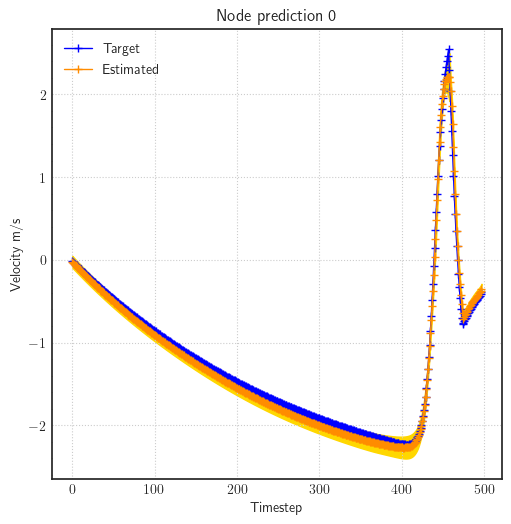

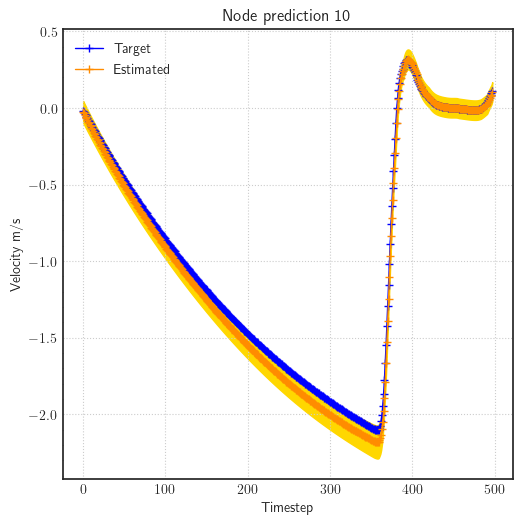

In [19]:
def plot_mean_and_variance_node(mean, var, gt, node_idx):
    fig = plt.figure(dpi=100)
    fig.set_size_inches(6, 6, forward=True)
    fig.clf()
    axes = fig.gca()

    axes.plot(range(len(mean)), gt[:, node_idx], color='blue', lw=1,
              label='Target', marker='+', zorder=3)

    axes.plot(range(len(mean)), mean[:, node_idx], lw=1,
              label='Estimated', marker='+', color='darkorange', zorder=3)
    mean_node = mean[:, node_idx]
    var_node = var[:, node_idx]
    var_1 = (mean_node - 2 * np.sqrt(var_node))
    var_2 = (mean_node + 2 * np.sqrt(var_node))
    axes.fill_between(range(len(mean)), var_1, var_2, color='gold', zorder=0)
    plt.grid(True)
    plt.legend(frameon=True)
    plt.ylabel("Velocity m/s")
    plt.xlabel("Timestep")
    axes.legend()
    plt.title("Node prediction " + str(node_idx))
    plt.subplots_adjust(0.15, 0.15, 0.9, 0.9)

    plt.show()


# Let's plot only two nodes
plot_mean_and_variance_node(gp_pred_arr, gp_var_arr, gt_arr, node_idx=0)
plot_mean_and_variance_node(gp_pred_arr, gp_var_arr, gt_arr, node_idx=10)



# Lets plot the RMSE, MAPE and NLL as well as give the mean

Mean RMSE= 0.061549387346789185
Mean MAPE= 0.12340288667315638
Mean NLL= -18.25597767084111


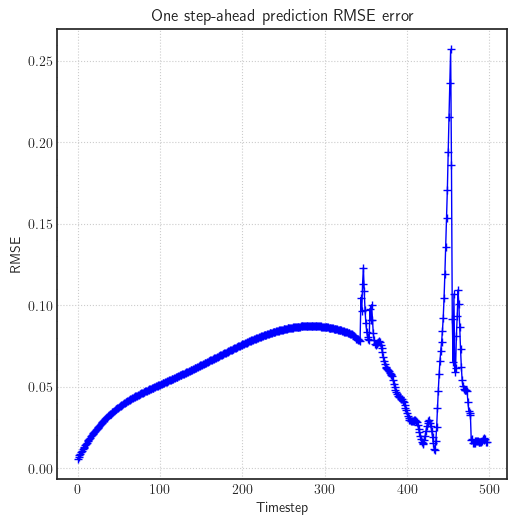

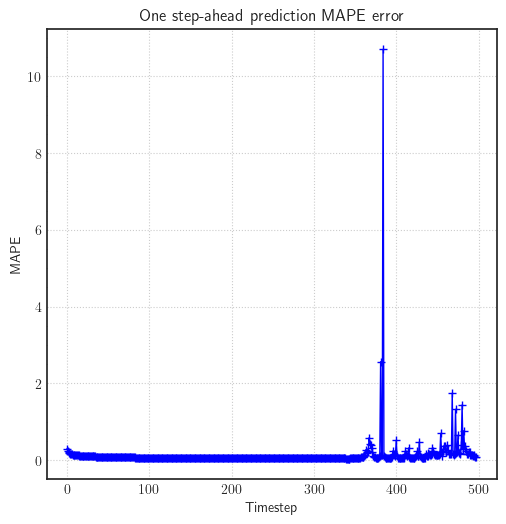

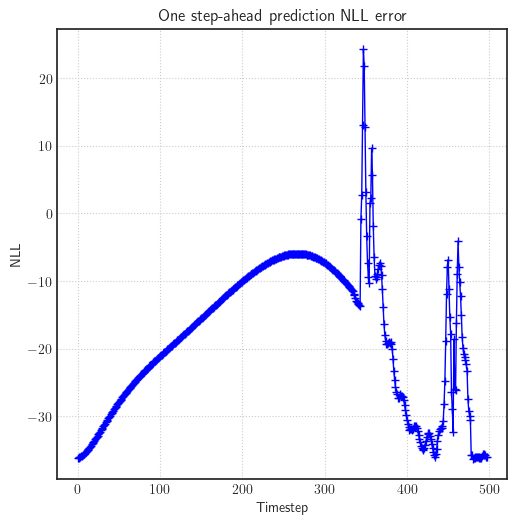

In [20]:
def plot_metric(metric_arr, metric_name):
    fig = plt.figure(dpi=100)
    fig.set_size_inches(6, 6, forward=True)
    fig.clf()
    axes = fig.gca()

    axes.plot(range(len(metric_arr)), metric_arr, color='blue', lw=1,
              label='Target', marker='+', zorder=3)
    plt.grid(True)
    plt.ylabel(metric_name)
    plt.xlabel("Timestep")
    plt.title("One step-ahead prediction " + metric_name + " error")
    plt.subplots_adjust(0.15, 0.15, 0.9, 0.9)

    plt.show()


print("Mean RMSE=", rmse_arr.mean())
print("Mean MAPE=", mape_arr.mean())
print("Mean NLL=", nll_arr.mean())

plot_metric(rmse_arr, "RMSE")
plot_metric(mape_arr, "MAPE")
plot_metric(nll_arr, "NLL")

